In [3]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd

import matplotlib.pyplot as plt

# get data
data = pd.read_pickle("./data/datasets/islets_rna_prot_dataset.pkl")
sample_metadata = pd.read_pickle("./data/datasets/islets_rna_prot_sample_metadata.pkl")
feature_metadata = pd.read_pickle("./data/datasets/islets_rna_prot_feature_metadata.pkl")

sys.path.append("src.py")
from src import Utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [F06] Median intensity correlation between proteomics and transcriptomics per cell type and treatment

Median aggregated correlation between proteomics and transcriptomics. Facets should be samples, different plots should be treatments. 

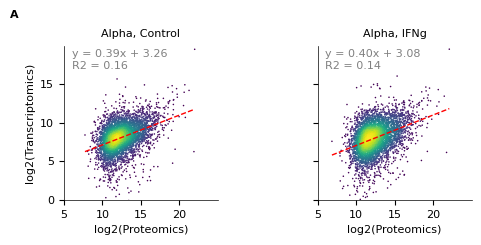

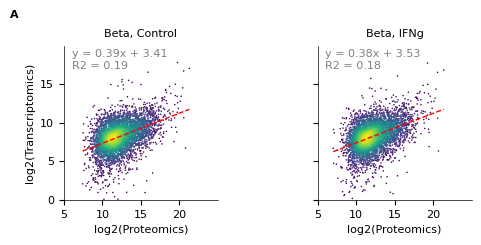

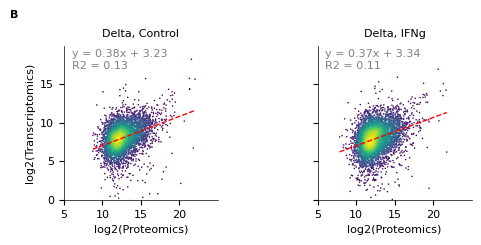

In [4]:
def figure_06_median_datasets(
        data: pd.DataFrame,
        sample_metadata: pd.DataFrame,
):

    # set pairs of samples to compare in faceted plot
    treatment_pairs = [
        ('control', 'control'), 
        ('ifng', 'ifng'),
    ]

    # str pairs as list of tuples
    sr_pairs = [
        ('alpha_proteomics', 'alpha_transcriptomics'),
        ('beta_proteomics', 'beta_transcriptomics'),
        ('delta_proteomics', 'delta_transcriptomics'),
    ]

    # compute median across all replicates for all pairs and visualize
    treatment_dataframes = {}
    for sr_p, sr_t in sr_pairs:

        # parse treatments
        sample_p = sr_p.split("_")[0]
        sample_t = sr_t.split("_")[0]
        if sample_p != sample_t:
            raise ValueError("Error in treatment parsing")

        sample_temp_dfs = []
        for t_p, t_t in treatment_pairs:
            
            # get corresponding row indices
            idx_p = sample_metadata[sample_metadata['sample_treat_readout'] == f'{sr_p.split("_")[0]}_{t_p}_{sr_p.split("_")[1]}'].index
            idx_t = sample_metadata[sample_metadata['sample_treat_readout'] == f'{sr_t.split("_")[0]}_{t_t}_{sr_t.split("_")[1]}'].index

            if len(idx_p) != 3 or len(idx_t) != 3:
                raise ValueError("Error in sample indexing")
            
            # get ids and value vectors
            ids = data.columns.values
            p_vec = data.loc[idx_p].median(axis = 0).values.flatten()
            t_vec = data.loc[idx_t].median(axis = 0).values.flatten()

            # assemble output
            treatment_dataframe = pd.DataFrame({
                'protein_group' : ids,
                'transcriptome_median_value' : t_vec,
                'proteome_median_value' : p_vec,
                'treat' : t_p,
                'sample_treat' : f'{sample_p}_{t_p}',
            })

            # store in dictionary
            sample_temp_dfs.append(treatment_dataframe)

        # concatenate dataframes for current treatment
        concatenated_t_df = pd.concat(sample_temp_dfs)

        # store in dictionary
        treatment_dataframes[sample_p] = concatenated_t_df

    # return dataframes in dictionary
    return treatment_dataframes

def figure_06_median_scatterplots(
        treatment_dataframes : pd.DataFrame = None,
):
    
    # generate enumeration
    plot_numbers = ['A', 'A', 'B']
    
    # iterate over sample_treatment pairs
    retression_coefficients = {}
    for plot_number, (sample, df) in zip(plot_numbers, treatment_dataframes.items()):

        # get data
        plot_df = df[['proteome_median_value', 'transcriptome_median_value']]
        plot_md = df[['treat', 'sample_treat']]

        def label_parse_regex(l):
            return l
        
        label_parse_dict = {
            'proteome_median_value' : 'log2(Proteomics)',
            'transcriptome_median_value' : 'log2(Transcriptomics)',
            'alpha_control' : 'Alpha, Control',
            'alpha_ifng' : 'Alpha, IFNg',
            'beta_control' : 'Beta, Control',
            'beta_ifng' : 'Beta, IFNg',
            'delta_control' : 'Delta, Control',
            'delta_ifng' : 'Delta, IFNg',
        }


        # scatterplot
        f, a = Utils.scatter(
            data = plot_df,
            metadata = plot_md, 
            x_col = 'proteome_median_value',
            y_col = 'transcriptome_median_value',
            color_column = 'sample_treat', 
            segments = 'facets',
            title = '',
            facet_titles = True, 
            density = True,
            figsize_x = 6,
            figsize_y = 2,
            xlim = (5, 25),
            ylim = (0, 20),
            xlabel = None,
            ylabel = None,
            label_lookup_dict = label_parse_dict,
            linear_regression = True,
            show_equation = True,
            enumerate_plot = plot_number,
            enumeration_xy = (-0.35, 1.2),
            x_tick_multiple = 5,
            y_tick_multiple = 5,
            aspect_equal = True,
        )

        # save plot
        Utils.save_figure(
            fig = f,
            filename = f"figure_06_median_scatterplot_{sample}.svg",
            output_dir = "./assets/20250423_revision_figures/",
            dpi = 300,
            paper_width = "single",
            paper_height = "0.5"
        )


f521ds = figure_06_median_datasets(data = data, sample_metadata = sample_metadata)
figure_06_median_scatterplots(f521ds)